In [1]:
import rasterio
import numpy as np
from rasterio.warp import reproject, Resampling
from rasterio.enums import Resampling
import os
import matplotlib.pyplot as plt

print("Libraries imported successfully!")
print("Rasterio version:", rasterio.__version__)

Libraries imported successfully!
Rasterio version: 1.4.3


In [2]:
os.getcwd()

'g:\\OneDrive\\casa0010dissertation\\00_06 jaipur code\\data_process'

In [3]:
import os
os.chdir("G:/OneDrive/casa0010dissertation/00_06 jaipur code")

In [4]:
# Set file paths
data_dir = "data/cleaned"
ghsl_path = f"{data_dir}/GHSL_Built_Characteristics.tif"
viirs_path = f"{data_dir}/VIIRS_Nighttime_Lights.tif"
output_path = f"{data_dir}/Illuminated_Residential_Volume.tif"

print("File paths:")
print(f"GHSL: {ghsl_path}")
print(f"VIIRS: {viirs_path}")
print(f"Output: {output_path}")

# Check if input files exist
print("\nChecking file existence:")
print(f"GHSL exists: {os.path.exists(ghsl_path)}")
print(f"VIIRS exists: {os.path.exists(viirs_path)}")

if not os.path.exists(ghsl_path):
    print("❌ Error: GHSL file not found!")
elif not os.path.exists(viirs_path):
    print("❌ Error: VIIRS file not found!")
else:
    print("✅ All input files found!")

File paths:
GHSL: data/cleaned/GHSL_Built_Characteristics.tif
VIIRS: data/cleaned/VIIRS_Nighttime_Lights.tif
Output: data/cleaned/Illuminated_Residential_Volume.tif

Checking file existence:
GHSL exists: True
VIIRS exists: True
✅ All input files found!


In [10]:
print("Loading GHSL data...")

with rasterio.open(ghsl_path) as ghsl_src:
    ghsl_data = ghsl_src.read(1)
    ghsl_profile = ghsl_src.profile
    ghsl_transform = ghsl_src.transform
    ghsl_crs = ghsl_src.crs

print(f"GHSL shape: {ghsl_data.shape}")
print(f"GHSL data type: {ghsl_data.dtype}")
print(f"GHSL CRS: {ghsl_crs}")
print(f"GHSL transform: {ghsl_transform}")
print(f"GHSL unique values: {np.unique(ghsl_data)}")

# Check for residential classes (11-15)
residential_classes = np.unique(ghsl_data[(ghsl_data >= 11) & (ghsl_data <= 15)])
print(f"Residential classes found: {residential_classes}")

Loading GHSL data...
GHSL shape: (2810, 2223)
GHSL data type: uint8
GHSL CRS: EPSG:32643
GHSL transform: | 10.00, 0.00, 568320.00|
| 0.00,-10.00, 2989590.00|
| 0.00, 0.00, 1.00|
GHSL unique values: [ 0  1  2  3  4  5 11 12 13 14 15 21 22 23 24]
Residential classes found: [11 12 13 14 15]


In [11]:
print("Loading VIIRS data...")

with rasterio.open(viirs_path) as viirs_src:
    viirs_profile = viirs_src.profile
    viirs_original_data = viirs_src.read(1)

print(f"VIIRS shape: {viirs_original_data.shape}")
print(f"VIIRS data type: {viirs_original_data.dtype}")
print(f"VIIRS CRS: {viirs_src.crs}")
print(f"VIIRS transform: {viirs_src.transform}")
print(f"VIIRS range: {np.nanmin(viirs_original_data):.3f} to {np.nanmax(viirs_original_data):.3f}")

# Check if resampling is needed
needs_resampling = (viirs_src.shape != ghsl_data.shape) or (viirs_src.transform != ghsl_transform)
print(f"Needs resampling: {needs_resampling}")

Loading VIIRS data...
VIIRS shape: (62, 49)
VIIRS data type: float32
VIIRS CRS: EPSG:32643
VIIRS transform: | 464.00, 0.00, 567936.00|
| 0.00,-464.00, 2990016.00|
| 0.00, 0.00, 1.00|
VIIRS range: 1.617 to 78.007
Needs resampling: True


In [12]:
# ===== CELL 5: Resample VIIRS to match GHSL grid =====
if needs_resampling:
    print("Resampling VIIRS to match GHSL grid...")

    with rasterio.open(viirs_path) as viirs_src:
        viirs_data = np.empty(ghsl_data.shape, dtype=np.float32)

        reproject(
            source=rasterio.band(viirs_src, 1),
            destination=viirs_data,
            src_transform=viirs_src.transform,
            src_crs=viirs_src.crs,
            dst_transform=ghsl_transform,
            dst_crs=ghsl_crs,
            resampling=Resampling.bilinear
        )

    print("✅ VIIRS resampling completed!")
else:
    viirs_data = viirs_original_data
    print("✅ No resampling needed - using original VIIRS data")

print(f"Final VIIRS shape: {viirs_data.shape}")
print(f"Final VIIRS range: {np.nanmin(viirs_data):.3f} to {np.nanmax(viirs_data):.3f}")

Resampling VIIRS to match GHSL grid...
✅ VIIRS resampling completed!
Final VIIRS shape: (2810, 2223)
Final VIIRS range: 1.661 to 77.753


In [13]:
# ===== CELL 6: Create residential mask =====
print("Creating residential mask (GHSL classes 11-15)...")

residential_mask = (ghsl_data >= 11) & (ghsl_data <= 15)
residential_pixels = np.sum(residential_mask)

print(f"Total pixels: {ghsl_data.size:,}")
print(f"Residential pixels: {residential_pixels:,}")
print(f"Residential coverage: {residential_pixels/ghsl_data.size*100:.2f}%")

# Show residential class distribution
for class_id in [11, 12, 13, 14, 15]:
    count = np.sum(ghsl_data == class_id)
    if count > 0:
        height = [1.5, 4.5, 10.5, 22.5, 35][class_id-11]
        print(f"Class {class_id} (≈{height}m height): {count:,} pixels")

Creating residential mask (GHSL classes 11-15)...
Total pixels: 6,246,630
Residential pixels: 1,707,653
Residential coverage: 27.34%
Class 11 (≈1.5m height): 152,713 pixels
Class 12 (≈4.5m height): 164,951 pixels
Class 13 (≈10.5m height): 908,541 pixels
Class 14 (≈22.5m height): 480,451 pixels
Class 15 (≈35m height): 997 pixels


In [14]:
# ===== CELL 7: Map GHSL classes to building heights =====
print("Mapping GHSL classes to building heights...")

height_map = np.zeros_like(ghsl_data, dtype=np.float32)
height_map[ghsl_data == 11] = 1.5   # ≤3m -> 1.5m average
height_map[ghsl_data == 12] = 4.5   # 3-6m -> 4.5m average
height_map[ghsl_data == 13] = 10.5  # 6-15m -> 10.5m average
height_map[ghsl_data == 14] = 22.5  # 15-30m -> 22.5m average
height_map[ghsl_data == 15] = 35.0  # >30m -> 35m average

# Check height mapping results
if residential_pixels > 0:
    print(f"Height range in residential areas: {np.min(height_map[residential_mask]):.1f} to {np.max(height_map[residential_mask]):.1f} meters")
    print(f"Average height in residential areas: {np.mean(height_map[residential_mask]):.1f} meters")
else:
    print("❌ No residential areas found!")

Mapping GHSL classes to building heights...
Height range in residential areas: 1.5 to 35.0 meters
Average height in residential areas: 12.5 meters


In [15]:
# ===== CELL 8: Calculate residential volume =====
print("Calculating residential volume...")

# Calculate volume: height * pixel area
pixel_area = 100  # 10m x 10m pixels = 100 m²
residential_volume = height_map * pixel_area

# Apply residential mask (set non-residential areas to 0)
residential_volume[~residential_mask] = 0

total_residential_volume = np.sum(residential_volume)
print(f"Total residential volume: {total_residential_volume:,.0f} m³")

if residential_pixels > 0:
    avg_volume_per_pixel = total_residential_volume / residential_pixels
    print(f"Average volume per residential pixel: {avg_volume_per_pixel:.0f} m³")

Calculating residential volume...
Total residential volume: 2,135,606,656 m³
Average volume per residential pixel: 1251 m³


In [16]:
# ===== CELL 9: Create illumination mask =====
print("Creating illumination mask (VIIRS > 0)...")

# Handle NaN values in VIIRS data
viirs_clean = np.nan_to_num(viirs_data, nan=0.0)
illuminated_mask = viirs_clean > 0

illuminated_pixels = np.sum(illuminated_mask)
print(f"Total illuminated pixels: {illuminated_pixels:,}")
print(f"Illumination coverage: {illuminated_pixels/ghsl_data.size*100:.2f}% of total area")

# Check illumination in residential areas
residential_illuminated = residential_mask & illuminated_mask
residential_illuminated_pixels = np.sum(residential_illuminated)

if residential_pixels > 0:
    illumination_rate = residential_illuminated_pixels / residential_pixels * 100
    print(f"Residential illuminated pixels: {residential_illuminated_pixels:,}")
    print(f"Residential illumination rate: {illumination_rate:.1f}%")

Creating illumination mask (VIIRS > 0)...
Total illuminated pixels: 6,246,630
Illumination coverage: 100.00% of total area
Residential illuminated pixels: 1,707,653
Residential illumination rate: 100.0%


In [ ]:
# ===== CELL 10: Calculate illuminated residential volume =====
print("Calculating final illuminated residential volume...")

# Combine masks: residential AND illuminated
combined_mask = residential_mask & illuminated_mask
illuminated_residential_volume = residential_volume.copy()
illuminated_residential_volume[~combined_mask] = 0

final_pixels = np.sum(combined_mask)
total_illuminated_volume = np.sum(illuminated_residential_volume)

print(f"Final illuminated residential pixels: {final_pixels:,}")
print(f"Total illuminated residential volume: {total_illuminated_volume:,.0f} m³")

if final_pixels > 0:
    min_volume = np.min(illuminated_residential_volume[illuminated_residential_volume > 0])
    max_volume = np.max(illuminated_residential_volume)
    avg_volume = total_illuminated_volume / final_pixels
    print(f"Volume range: {min_volume:.0f} to {max_volume:.0f} m³")
    print(f"Average volume per pixel: {avg_volume:.0f} m³")

# ===== Additional: Calculate Residential Light Intensity (resampled) =====
print("\nCalculating Residential Light Intensity with proper resampling...")

# Use the resampled VIIRS data and apply residential mask
residential_light_intensity = viirs_data.copy()  # This is already resampled to 10m grid
residential_light_intensity[~residential_mask] = 0  # Set non-residential areas to 0

# Calculate statistics
residential_light_pixels = np.sum(residential_mask & (viirs_data > 0))
if residential_light_pixels > 0:
    avg_light_intensity = np.sum(residential_light_intensity) / residential_light_pixels
    max_light_intensity = np.max(residential_light_intensity)
    print(f"Residential light pixels: {residential_light_pixels:,}")
    print(f"Average residential light intensity: {avg_light_intensity:.2f}")
    print(f"Max residential light intensity: {max_light_intensity:.2f}")

# Save Residential Light Intensity with proper resampling
residential_light_path = f"{data_dir}/Residential_Light_Intensity_10m.tif"
print(f"Saving resampled Residential Light Intensity to: {residential_light_path}")

with rasterio.open(residential_light_path, 'w', **output_profile**) as dst:
    dst.write(residential_light_intensity, 1)

print("✅ Resampled Residential Light Intensity saved!")

In [20]:
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os




# ===== CELL 11: Save the result =====
print(f"Saving result to: {output_path}")

# Create output directory if it doesn't exist
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Update profile for output
output_profile = ghsl_profile.copy()
output_profile.update({
    'dtype': 'float32',
    'nodata': 0,
    'compress': 'lzw'
})

# Save the result
with rasterio.open(output_path, 'w', **output_profile) as dst:
    dst.write(illuminated_residential_volume, 1)

print("✅ File saved successfully!")

# Verify the saved file
if os.path.exists(output_path):
    file_size = os.path.getsize(output_path) / (1024*1024)  # MB
    print(f"Output file size: {file_size:.1f} MB")
else:
    print("❌ Error: Output file was not created!")

Saving result to: data/cleaned/Illuminated_Residential_Volume.tif
✅ File saved successfully!
Output file size: 1.0 MB


Creating visualization...
Loaded Residential Light Intensity: (2810, 2223)


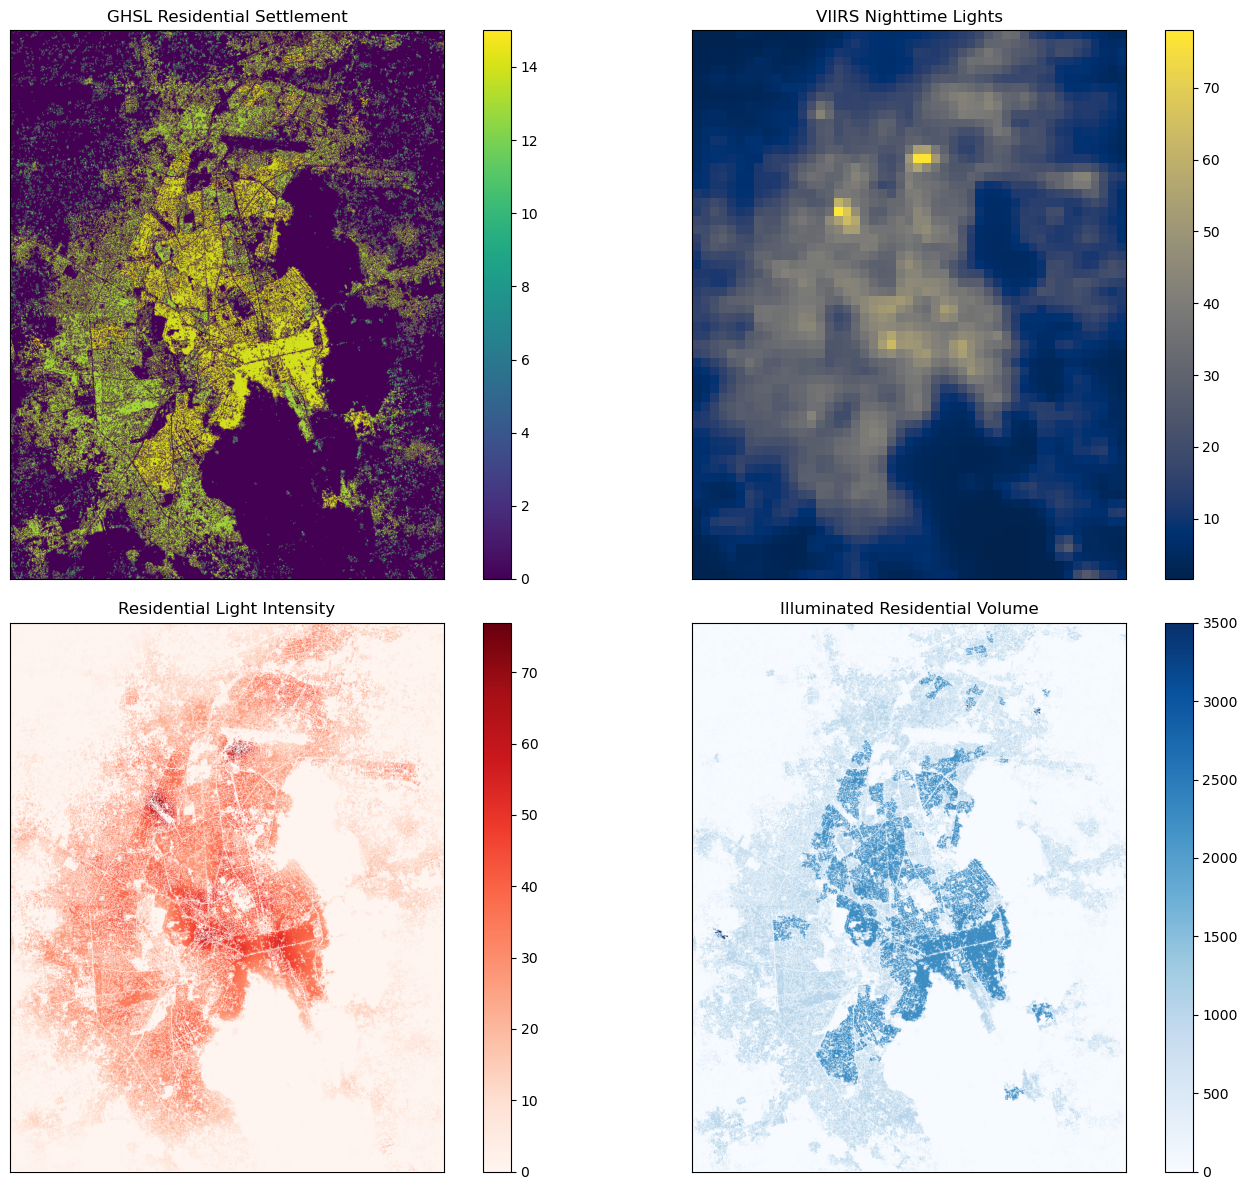

In [25]:
# ===== CELL 13: Create visualization (optional) =====
print("Creating visualization...")

# Load Residential Light Intensity for visualization
residential_light_path = "data/cleaned/Residential_Light_Intensity_10m.tif"
if os.path.exists(residential_light_path):
  with rasterio.open(residential_light_path) as src:
    residential_light_data = src.read(1)
  print(f"Loaded Residential Light Intensity: {residential_light_data.shape}")
else:
  print(f"Warning: {residential_light_path} not found, using calculated data")
  residential_light_data = np.where(residential_mask, viirs_data, np.nan)

# Load VIIRS Nighttime Lights
viirs_path = "data/cleaned/VIIRS_Nighttime_Lights.tif"
with rasterio.open(viirs_path) as src:
  viirs_data = src.read(1)

# Load Illuminated Residential Volume
illuminated_volume_path = "data/cleaned/Illuminated_Residential_Volume.tif"
with rasterio.open(illuminated_volume_path) as src:
  illuminated_residential_volume = src.read(1)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. GHSL residential classes
residential_display = np.where(residential_mask, ghsl_data, 0)
im1 = axes[0,0].imshow(residential_display, cmap='viridis', origin='lower')
axes[0,0].set_title('GHSL Residential Settlement')
axes[0,0].set_xticks([])  # Hide x ticks
axes[0,0].set_yticks([])  # Hide y ticks
plt.colorbar(im1, ax=axes[0,0])

# 2. VIIRS illumination
im2 = axes[0,1].imshow(viirs_data, cmap='cividis', origin='lower')
axes[0,1].set_title('VIIRS Nighttime Lights')
axes[0,1].set_xticks([])  # Hide x ticks
axes[0,1].set_yticks([])  # Hide y ticks
plt.colorbar(im2, ax=axes[0,1])

# 3. Residential Light Intensity
im3 = axes[1,0].imshow(residential_light_data, cmap='Reds', origin='lower')
axes[1,0].set_title('Residential Light Intensity')
axes[1,0].set_xticks([])  # Hide x ticks
axes[1,0].set_yticks([])  # Hide y ticks
plt.colorbar(im3, ax=axes[1,0])

# 4. Final result
im4 = axes[1,1].imshow(illuminated_residential_volume, cmap='Blues', origin='lower')
axes[1,1].set_title('Illuminated Residential Volume')
axes[1,1].set_xticks([])  # Hide x ticks
axes[1,1].set_yticks([])  # Hide y ticks
plt.colorbar(im4, ax=axes[1,1])

plt.savefig('image/process/pop_raster_var_02.png')

plt.tight_layout()

# BEGIN: Draw city boundary
# END: Draw city boundary
